In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, 'functions/')
from interpolation_functions import *
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':15})

# Interpolate and Create nc File

In [2]:
###### levante #####

#mesh_path = '/work/ab0995/a270185/meshes/AO_40/fesom.mesh.diag.nc'


##### juwels #####

# 1 km
mesh_path = '/p/largedata/hhb19/li1/scratch_backup/AWI-Mesh1/A0_40_1km_mesh/fesom.mesh.diag.nc'
# 4.5 km
#mesh_path = '/p/largedata/hhb19/li1/scratch_backup/fesom2_runs_2024_4km11/fesom.mesh.diag.nc'

In [3]:
fesom_mesh = xr.open_dataset(mesh_path)

model_lon = fesom_mesh.lon.values
model_lat = fesom_mesh.lat.values

In [9]:
###### levante ######

#data_path = '/work/ab0995/a270185/AO_1km_ice/'
#save_in_path = '/work/bk1377/a270230/data/interpolated_fesom_output/'


###### juwels ######

### AWICM forcing, with CVMIX mixing scheme (use this one) ###
# 1 km
data_path = '/p/largedata/hhb19/li1/scratch_backup/fesom2_runs_2024/3fesom2_1km_AWICM_CVMIX_2010/results/'
#data_path = '/p/largedata/hhb19/li1/scratch_backup/fesom2_runs_2024/3fesom2_1km_AWICM_CVMIX_2090/results/'
# 4.5 km
#data_path = '/p/largedata/hhb19/li1/scratch_backup/fesom2_runs_2024_4km11/2fesom2_farc_AWICM_CVMIX_2010/results/'
#data_path = '/p/largedata/hhb19/li1/scratch_backup/fesom2_runs_2024_4km11/2fesom2_farc_AWICM_CVMIX_2090/results/'

### AWICM forcing corrected by JRA55 ###
# 2013-2020 #
#data_path = '/p/largedata/hhb19/li1/scratch_backup/fesom2_runs_2023_newVersion/3fesom2_farc_AWICM_KPP_forcingCorrect_MakeRelaxsalt_new_2010/results/'
# 2093 - 2100 #
#data_path = '/p/largedata/hhb19/li1/scratch_backup/fesom2_runs_2023_newVersion/3fesom2_farc_AWICM_KPP_forcingCorrect_MakeRelaxsalt_new_2090_chhb19/results/'

save_in_path = '/p/scratch/chhb19/gaertner2/interpolated_fesom_output/1km/'

In [10]:
years = [2013]

In [8]:
years = [i for i in range(2093, 2101)]

In [14]:
# create interpolation grid
box = (-180, 180, 70, 90)
res = (1000, 1000)
proj = 'np'
int_x_steps, int_y_steps, int_lons, int_lats = region_cartopy(box, res, proj)

# calculate distance to and index of the fesom grid point closest to
# the grid point in the interpolation grid
distances, inds = create_indexes_and_distances(model_lon, model_lat,
                                               int_lons, int_lats,
                                               k=1, workers=10)

for year in years:
    
    ### load the data ###
    
    a_ice = xr.open_dataset(data_path + f'a_ice.fesom.{year}.nc').a_ice
    h_ice = xr.open_dataset(data_path + f'm_ice.fesom.{year}.nc').m_ice
    u_ice = xr.open_dataset(data_path + f'uice.fesom.{year}.nc').uice
    v_ice = xr.open_dataset(data_path + f'vice.fesom.{year}.nc').vice
    
    #ntimesteps = len(a_ice.time)
    ntimesteps = 365
    save_as_name = save_in_path + f'1km_{year}.nc'
    
    ### interpolate and create nc file ###

    # do the nearest neighbor interpolation
    a_ice_int, h_ice_int, u_ice_int, v_ice_int = interpolate(
        a_ice, h_ice, u_ice, v_ice,
        inds, distances, ntimesteps, shape = int_lons.shape
    )

    create_nc_file(a_ice_int, h_ice_int, u_ice_int, v_ice_int,
                   int_lons, int_lats, ntimesteps, save_as_name)

# Plot the Interpolated Data

In [15]:
file = xr.open_dataset(save_in_path + '1km_2013.nc')

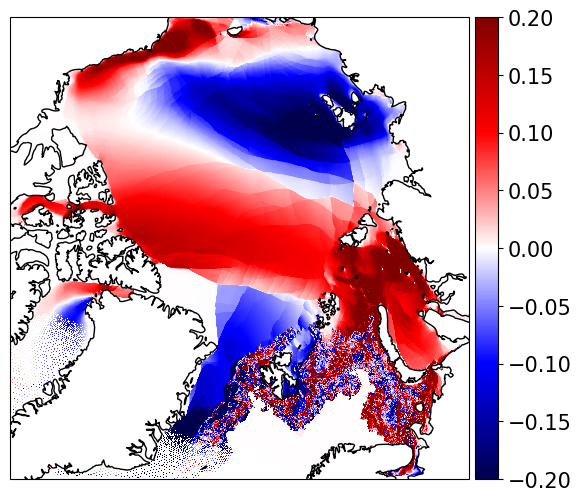

In [16]:
fig = plt.figure(figsize=[8, 6])
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines(zorder=3)
im = ax.pcolormesh(file.ULON, file.ULAT,
                   file.U.isel(time=-1),
                   cmap = 'seismic',
                   vmin=-0.2,vmax=0.2,
                   transform=ccrs.PlateCarree())
plt.colorbar(im, pad=0.01)